In [1]:
%pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/repo.html
%pip install labml-nn

Looking in links: https://data.dgl.ai/wheels/torch-2.3/repo.html
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install pydantic


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!nvidia-smi

Fri May  2 15:18:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0              13W /  50W |    119MiB /  4096MiB |     19%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import argparse
import time
from torch import optim
import torch.nn.functional as F

c:\Users\Taneem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
c:\Users\Taneem\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class LinearNeuralNetwork(nn.Module):
    def __init__(self, nfeat, nclass, bias=True):
        super(LinearNeuralNetwork, self).__init__()
        self.W = nn.Linear(nfeat, nclass, bias=bias)

    def forward(self, x):
        return self.W(x)


def symmetric_normalize_adjacency(graph):
    """Symmetric normalize graph adjacency matrix."""
    indices = torch.stack(graph.edges())
    n = graph.num_nodes()
    adj = dglsp.spmatrix(indices, shape=(n, n))
    deg_invsqrt = dglsp.diag(adj.sum(0)) ** -0.5
    return deg_invsqrt @ adj @ deg_invsqrt


def model_test(model, embeds):
    model.eval()
    with torch.no_grad():
        output = model(embeds)
        pred = output.argmax(dim=-1)
        test_mask, tv_mask = model.test_mask, model.tv_mask
        loss_tv = F.mse_loss(output[tv_mask], model.label_one_hot[tv_mask])
    accs = []
    for mask in [tv_mask, test_mask]:
        accs.append(
            float((pred[mask] == model.label[mask]).sum() / mask.sum()))
    return loss_tv.item(), accs[0], accs[1], pred

In [6]:
class OGC(nn.Module):
    def __init__(self, graph):
        super(OGC, self).__init__()
        self.linear_clf = LinearNeuralNetwork(
            nfeat=graph.ndata["feat"].shape[1],
            nclass=graph.ndata["label"].max().item() + 1,
            bias=False,
        )

        self.label = graph.ndata["label"]
        self.label_one_hot = F.one_hot(graph.ndata["label"]).float()
        # LIM trick, else use both train and val set to construct this matrix.
        self.label_idx_mat = dglsp.diag(graph.ndata["train_mask"]).float()

        self.test_mask = graph.ndata["test_mask"]
        self.tv_mask = graph.ndata["train_mask"] + graph.ndata["val_mask"]

    def forward(self, x):
        return self.linear_clf(x)

    def update_embeds(self, embeds, adj, X, args):
        """Update embeddings using PPR propagation and supervised loss."""
        pred_label = self(embeds).data
        clf_weight = self.linear_clf.W.weight.data

        # PPR propagation: αX + (1-α)D⁻¹/²AD⁻¹/²U
        # Teleport (reset) to raw features: αX
        # Propagate with normalized adjacency: (1-α)D⁻¹/²AD⁻¹/²U

        # Update the smoothness loss via PPR.
        embeds = args.alpha * X + (1 - args.alpha) * dglsp.spmm(adj, embeds)

        # Update the supervised loss via SEB.
        deriv_sup = 2 * dglsp.matmul(
            dglsp.spmm(self.label_idx_mat, -self.label_one_hot + pred_label),
            clf_weight,
        )
        embeds = embeds - args.lr_sup * deriv_sup

        args.lr_sup *= args.decline
        return embeds

In [7]:
from dgl import AddSelfLoop
from dgl.data import CiteseerGraphDataset

parser = argparse.ArgumentParser()
args = parser.parse_args([])
args.dataset = "citeseer"
args.decline = 0.9
args.lr_sup = 0.001
args.lr_clf = 0.5
args.alpha = 0.1  # PPR teleport probability
args.max_sim_rate = 0.995
args.max_patience = 2
args.device = torch.device("cpu")

In [8]:
transform = AddSelfLoop()
data = CiteseerGraphDataset(transform=transform)
graph = data[0].to(args.device)

# Create normalized adjacency matrix
features = graph.ndata["feat"].to(args.device)
adj = symmetric_normalize_adjacency(graph).to(args.device)

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [9]:
graph.has_edges_between([0], [1])

tensor([False])

In [10]:
def train(model, embeds, adj, args):
    """Modified training loop with PPR propagation"""
    X = embeds.clone().detach()  # Store original features for teleport
    patience = 0
    _, _, last_acc, last_output = model_test(model, embeds)

    tv_mask = model.tv_mask
    optimizer = optim.SGD(model.parameters(), lr=args.lr_clf)

    for i in range(64):
        model.train()
        output = model(embeds)
        loss_tv = F.cross_entropy(
            output[tv_mask], model.label_one_hot[tv_mask], reduction="sum"
        )
        optimizer.zero_grad()
        loss_tv.backward()
        optimizer.step()

        # Update with PPR propagation and supervised loss
        embeds = model.update_embeds(embeds, adj, X, args)

        loss_tv, acc_tv, acc_test, pred = model_test(model, embeds)
        print(
            f"Epoch {i+1}: TV Loss {loss_tv:.4f} | TV Acc {acc_tv:.4f} | Test Acc {acc_test:.4f}")

        sim_rate = (pred == last_output).sum().item()/pred.shape[0]
        if sim_rate > args.max_sim_rate:
            patience += 1
            if patience > args.max_patience:
                break
        last_acc = acc_test
        last_output = pred

    return last_acc

In [11]:
model = OGC(graph).to(args.device)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters())}")

Model Parameters: 22218


In [12]:
# start_time = time.time()
# res = train(model, features, adj, args)
# time_tot = time.time() - start_time

# print(f"Test Acc: {res:.4f}")
# print(f"Total Time: {time_tot:.4f}")

In [13]:
import numpy as np

test_accs = []
total_times = []

for run in range(20):
    print(f"\nRun {run + 1}/20")

    # Reload fresh graph and features
    transform = AddSelfLoop()
    data = CiteseerGraphDataset(transform=transform)
    graph = data[0].to(args.device)

    features = graph.ndata["feat"].to(args.device)
    adj = symmetric_normalize_adjacency(graph).to(args.device)

    # Reset args
    args.lr_sup = 0.001  # fresh value!

    # New model
    model = OGC(graph).to(args.device)

    optimizer = optim.SGD(model.parameters(), lr=args.lr_clf)

    start_time = time.time()
    test_acc = train(model, features, adj, args)
    time_tot = time.time() - start_time

    test_accs.append(test_acc)
    total_times.append(time_tot)

# Calculate statistics
test_accs = np.array(test_accs) * 100  # Convert to percentage
mean_acc = np.mean(test_accs)
std_acc = np.std(test_accs)

print(f"Test Acc: {mean_acc:.1f}±{std_acc:.1f}")
print(f"Average Time: {np.mean(total_times):.4f}s")


Run 1/20
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 1: TV Loss 0.1551 | TV Acc 0.7403 | Test Acc 0.6820
Epoch 2: TV Loss 0.1459 | TV Acc 0.7597 | Test Acc 0.7140
Epoch 3: TV Loss 0.1381 | TV Acc 0.7677 | Test Acc 0.7200
Epoch 4: TV Loss 0.1310 | TV Acc 0.7710 | Test Acc 0.7210
Epoch 5: TV Loss 0.1250 | TV Acc 0.7661 | Test Acc 0.7240
Epoch 6: TV Loss 0.1198 | TV Acc 0.7726 | Test Acc 0.7280
Epoch 7: TV Loss 0.1155 | TV Acc 0.7758 | Test Acc 0.7310
Epoch 8: TV Loss 0.1121 | TV Acc 0.7806 | Test Acc 0.7330
Epoch 9: TV Loss 0.1095 | TV Acc 0.7774 | Test Acc 0.7330
Epoch 10: TV Loss 0.1075 | TV Acc 0.7758 | Test Acc 0.7330
Epoch 11: TV Loss 0.1062 | TV Acc 0.7806 | Test Acc 0.7360
Epoch 12: TV Loss 0.1054 | TV Acc 0.7823 | Test Acc 0.7380

Run 2/20
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumVa

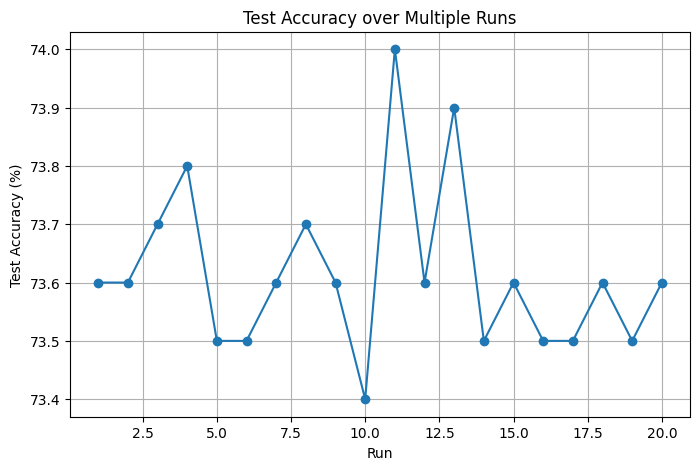

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(test_accs) + 1), test_accs, marker='o')
plt.title("Test Accuracy over Multiple Runs")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()